In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import os
import numpy as np
import keras
from keras import layers
from keras import backend as K
from keras.callbacks import LearningRateScheduler
from keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Lambda,Conv2DTranspose, Dropout
from keras.models import Model
import keras.backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from skimage.transform import resize
from keras.layers import Lambda
from keras import optimizers

In [ ]:
def load_images_from_folder(folder_path, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img = plt.imread(img_path)
            img_resized = resize(img, target_size + (3,))  # Ensure 3 channels for RGB
            images.append(img_resized)
    return images

In [ ]:
no_folder_path = '/content/drive/MyDrive/1'
yes_folder_path = '/content/drive/MyDrive/2'

# Load and preprocess RGB images from each folder
images_no = load_images_from_folder(no_folder_path)
images_yes = load_images_from_folder(yes_folder_path)
all_images = np.concatenate([images_no, images_yes], axis=0)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
labels_no = np.zeros(len(images_no))
labels_yes = np.ones(len(images_yes))
all_labels = np.concatenate([labels_no, labels_yes], axis=0)

# Shuffle the dataset
indices = np.arange(len(all_images))
np.random.shuffle(indices)

shuffled_images = all_images[indices]
shuffled_labels = all_labels[indices]

# Split into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    shuffled_images, shuffled_labels, test_size=0.2, random_state=42
)

# Ensure the number of training samples is a multiple of the batch size
num_train_samples = len(train_images)
batch_size = 28
num_batches = num_train_samples // batch_size
num_train_samples = num_batches * batch_size

# Ensure the number of testing samples is a multiple of the batch size
num_test_samples = len(test_images)
num_batches_test = num_test_samples // batch_size
num_test_samples = num_batches_test * batch_size

# Resize images to (28, 28, 1)
train_images_resized = []
for img in train_images[:num_train_samples]:
    img_resized = resize(img, (28, 28, 3))
    train_images_resized.append(img_resized)

# Convert the resized images to numpy array
train_images_resized = np.array(train_images_resized)

# Reshape the images for compatibility with the VAE model
train_images_flat = train_images_resized.reshape((num_train_samples, -1))

# Resize test images to (28, 28, 1)
test_images_resized = []
for img in test_images[:num_test_samples]:
    img_resized = resize(img, (28, 28, 3))
    test_images_resized.append(img_resized)

# Convert the resized test images to numpy array
test_images_resized = np.array(test_images_resized)

# Reshape test images for compatibility with the VAE model
test_images_flat = test_images_resized.reshape((num_test_samples, -1))

original_dim = 28 * 28 * 3
intermediate_dim = 1000
latent_dim = 80

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
h = layers.Dense(512, activation='relu')(h)
h = layers.Dense(256, activation='relu')(h)

z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)

decoder = keras.Model(latent_inputs, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')



# Adjusted learning rate
optimizer = keras.optimizers.Adam(lr=0.000225)

reconstruction_loss = keras.losses.mean_squared_error(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss +kl_loss)
vae.add_loss(vae_loss)



# Compile and train the VAE model
vae.compile(optimizer=optimizer)

# Adjust the input shape to match the expected shape of the VAE model
train_images_flat_reshaped = train_images_flat.reshape((num_train_samples, -1))

vae.fit(train_images_flat_reshaped, train_images_flat_reshaped,
        epochs=1000,
        batch_size=batch_size,
        validation_data=(test_images_flat.reshape((len(test_images_flat), -1)),
                         test_images_flat.reshape((len(test_images_flat), -1))),
        #callbacks=[early_stopping]
        )

# Generate new images using the trained VAE
generated_images = vae.predict(test_images_flat)
# Create a list of indices for both training and testing sets
indices_train = np.arange(num_train_samples)
indices_test = np.arange(num_test_samples)

# Visualize original and generated images for the testing set
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images from the testing set
    original_index = indices_test[i]
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[original_index])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Generated images from the testing set
    generated_index = original_index  # Use the same index for generated images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(generated_images[generated_index].reshape(28, 28, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Epoch 1/1000
6/6 [==============================] - 3s 46ms/step - loss: 207.0863 - val_loss: 203.6997
Epoch 2/1000
6/6 [==============================] - 0s 9ms/step - loss: 189.8031 - val_loss: 187.7091
Epoch 3/1000
6/6 [==============================] - 0s 9ms/step - loss: 175.2937 - val_loss: 174.7576
Epoch 4/1000
6/6 [==============================] - 0s 9ms/step - loss: 164.0961 - val_loss: 166.4881
Epoch 5/1000
6/6 [==============================] - 0s 9ms/step - loss: 157.5510 - val_loss: 150.6211
Epoch 6/1000
6/6 [==============================] - 0s 9ms/step - loss: 143.3363 - val_loss: 142.0552
Epoch 7/1000
6/6 [==============================] - 0s 9ms/step - loss: 136.8403 - val_loss: 132.7375
Epoch 8/1000
6/6 [==============================] - 0s 9ms/step - loss: 130.4456 - val_loss: 125.4520
Epoch 9/1000
6/6 [==============================] - 0s 9ms/step - loss: 131.9124 - val_loss: 132.3742
Epoch 10/1000
6/6 [==============================] - 0s 9ms/step - loss: 124.4208

In [ ]:
from ipywidgets import interact, widgets
from IPython.display import display

# Function to generate images based on the specified count
def generate_images(num_images):
    # Generate new images using the trained VAE
    generated_images = vae.predict(test_images_flat[:num_images])

    # Visualize original and generated images for the testing set
    n = num_images * 2  # Double the number of images
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images from the testing set
        original_index = indices_test[i % len(indices_test)]
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_images[original_index])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Generated images from the testing set
        generated_index = original_index  # Use the same index for generated images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(generated_images[i % len(generated_images)].reshape(28, 28, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

# Create an interactive slider for the number of images
image_count_slider = widgets.IntSlider(value=28, min=1, max=50, step=1, description='Image Count')

# Define the update function for the slider
def update_slider(num_images):
    generate_images(num_images)

# Display the slider and update function
interact(update_slider, num_images=image_count_slider)


interactive(children=(IntSlider(value=28, description='Image Count', max=50, min=1), Output()), _dom_classes=(…

<function __main__.update_slider(num_images)>

Epoch 1/1000
6/6 [==============================] - 4s 67ms/step - loss: 196.9128 - val_loss: 176.4752
Epoch 2/1000
6/6 [==============================] - 0s 21ms/step - loss: 177.4028 - val_loss: 167.5216
Epoch 3/1000
6/6 [==============================] - 0s 20ms/step - loss: 152.1795 - val_loss: 149.4333
Epoch 4/1000
6/6 [==============================] - 0s 17ms/step - loss: 139.1214 - val_loss: 139.6590
Epoch 5/1000
6/6 [==============================] - 0s 17ms/step - loss: 124.3204 - val_loss: 130.4165
Epoch 6/1000
6/6 [==============================] - 0s 16ms/step - loss: 114.2938 - val_loss: 124.6454
Epoch 7/1000
6/6 [==============================] - 0s 13ms/step - loss: 108.0772 - val_loss: 118.0840
Epoch 8/1000
6/6 [==============================] - 0s 12ms/step - loss: 102.8456 - val_loss: 114.5684
Epoch 9/1000
6/6 [==============================] - 0s 12ms/step - loss: 99.4278 - val_loss: 111.1350
Epoch 10/1000
6/6 [==============================] - 0s 12ms/step - loss: 

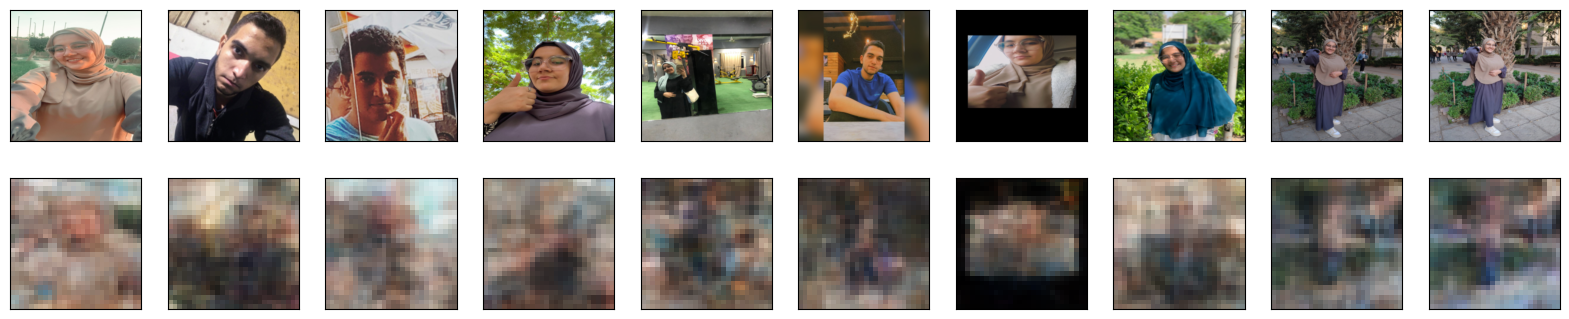

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
labels_no = np.zeros(len(images_no))
labels_yes = np.ones(len(images_yes))
all_labels = np.concatenate([labels_no, labels_yes], axis=0)

# Shuffle the dataset
indices = np.arange(len(all_images))
np.random.shuffle(indices)

shuffled_images = all_images[indices]
shuffled_labels = all_labels[indices]

# Split into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    shuffled_images, shuffled_labels, test_size=0.2, random_state=42
)

# Ensure the number of training samples is a multiple of the batch size
num_train_samples = len(train_images)
batch_size = 28
num_batches = num_train_samples // batch_size
num_train_samples = num_batches * batch_size

# Ensure the number of testing samples is a multiple of the batch size
num_test_samples = len(test_images)
num_batches_test = num_test_samples // batch_size
num_test_samples = num_batches_test * batch_size

# Resize images to (28, 28, 1)
train_images_resized = []
for img in train_images[:num_train_samples]:
    img_resized = resize(img, (28, 28, 3))  # Ensure 3 channels for RGB
    train_images_resized.append(img_resized)

# Convert the resized images to numpy array
train_images_resized = np.array(train_images_resized)

# Reshape the images for compatibility with the VAE model
train_images_flat = train_images_resized.reshape((num_train_samples, -1))

# Resize test images to (28, 28, 1)
test_images_resized = []
for img in test_images[:num_test_samples]:
    img_resized = resize(img, (28, 28, 3))  # Ensure 3 channels for RGB
    test_images_resized.append(img_resized)

# Convert the resized test images to numpy array
test_images_resized = np.array(test_images_resized)

# Reshape test images for compatibility with the VAE model
test_images_flat = test_images_resized.reshape((num_test_samples, -1))

original_dim = 28 * 28 * 3  # Adjusted for RGB images
intermediate_dim = 1000
latent_dim = 80

inputs = Input(shape=(original_dim,))
inputs_reshaped = Reshape((28, 28, 3))(inputs)
h = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs_reshaped)
h = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(h)
h = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(h)
h = Flatten()(h)

z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

# Sampling layer
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(7 * 7 * 128, activation='relu')(decoder_input)
x = Reshape((7, 7, 128))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

# Connect encoder and decoder
outputs = x
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
decoder = Model(decoder_input, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])

# VAE model
vae = Model(inputs, outputs, name='vae_mlp')

# Loss function and compile
reconstruction_loss = K.sum(K.square(Flatten()(inputs) - Flatten()(outputs)), axis=-1)
kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
optimizer = keras.optimizers.Adam(lr=0.000225)
vae.compile(optimizer=optimizer)



# Compile and train the VAE model


# Adjust the input shape to match the expected shape of the VAE model
train_images_flat_reshaped = train_images_flat.reshape((num_train_samples, -1))

vae.fit(train_images_flat_reshaped, train_images_flat_reshaped,
        epochs=1000,
        batch_size=batch_size,
        validation_data=(test_images_flat.reshape((len(test_images_flat), -1)),
                         test_images_flat.reshape((len(test_images_flat), -1))),
        #callbacks=[early_stopping]
        )

# Generate new images using the trained VAE
generated_images = vae.predict(test_images_flat)
# Create a list of indices for both training and testing sets
indices_train = np.arange(num_train_samples)
indices_test = np.arange(num_test_samples)

# Visualize original and generated images for the testing set
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images from the testing set
    original_index = indices_test[i]
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[original_index])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Generated images from the testing set
    generated_index = original_index  # Use the same index for generated images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(generated_images[generated_index].reshape(28, 28, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Epoch 1/1000
6/6 [==============================] - 3s 67ms/step - loss: 202.0460 - val_loss: 185.0996
Epoch 2/1000
6/6 [==============================] - 0s 18ms/step - loss: 189.8887 - val_loss: 174.2840
Epoch 3/1000
6/6 [==============================] - 0s 21ms/step - loss: 176.3782 - val_loss: 143.2334
Epoch 4/1000
6/6 [==============================] - 0s 20ms/step - loss: 153.1719 - val_loss: 131.5269
Epoch 5/1000
6/6 [==============================] - 0s 19ms/step - loss: 136.9217 - val_loss: 121.5975
Epoch 6/1000
6/6 [==============================] - 0s 18ms/step - loss: 125.1018 - val_loss: 111.0868
Epoch 7/1000
6/6 [==============================] - 0s 14ms/step - loss: 118.0979 - val_loss: 108.3797
Epoch 8/1000
6/6 [==============================] - 0s 13ms/step - loss: 112.4850 - val_loss: 102.9216
Epoch 9/1000
6/6 [==============================] - 0s 12ms/step - loss: 109.5512 - val_loss: 99.6663
Epoch 10/1000
6/6 [==============================] - 0s 12ms/step - loss: 

1/1 [==============================] - 0s 205ms/step


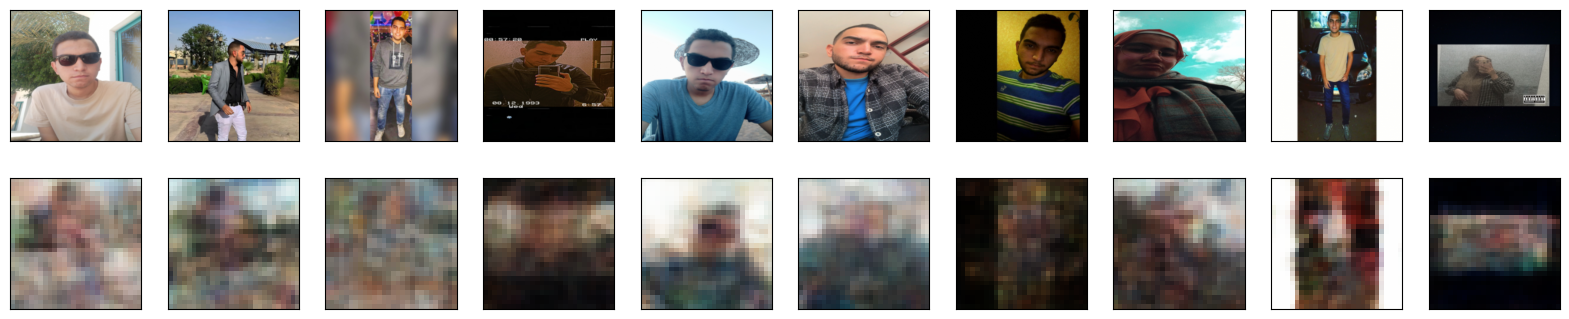

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
labels_no = np.zeros(len(images_no))
labels_yes = np.ones(len(images_yes))
all_labels = np.concatenate([labels_no, labels_yes], axis=0)

# Shuffle the dataset
indices = np.arange(len(all_images))
np.random.shuffle(indices)

shuffled_images = all_images[indices]
shuffled_labels = all_labels[indices]

# Split into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    shuffled_images, shuffled_labels, test_size=0.2, random_state=42
)

# Ensure the number of training samples is a multiple of the batch size
num_train_samples = len(train_images)
batch_size = 28
num_batches = num_train_samples // batch_size
num_train_samples = num_batches * batch_size

# Ensure the number of testing samples is a multiple of the batch size
num_test_samples = len(test_images)
num_batches_test = num_test_samples // batch_size
num_test_samples = num_batches_test * batch_size

# Resize images to (28, 28, 1)
train_images_resized = []
for img in train_images[:num_train_samples]:
    img_resized = resize(img, (28, 28, 3))  # Ensure 3 channels for RGB
    train_images_resized.append(img_resized)

# Convert the resized images to numpy array
train_images_resized = np.array(train_images_resized)

# Reshape the images for compatibility with the VAE model
train_images_flat = train_images_resized.reshape((num_train_samples, -1))

# Resize test images to (28, 28, 1)
test_images_resized = []
for img in test_images[:num_test_samples]:
    img_resized = resize(img, (28, 28, 3))  # Ensure 3 channels for RGB
    test_images_resized.append(img_resized)

# Convert the resized test images to numpy array
test_images_resized = np.array(test_images_resized)

# Reshape test images for compatibility with the VAE model
test_images_flat = test_images_resized.reshape((num_test_samples, -1))

original_dim = 28 * 28 * 3  # Adjusted for RGB images
intermediate_dim = 1000
latent_dim = 80

inputs = Input(shape=(original_dim,))
inputs_reshaped = Reshape((28, 28, 3))(inputs)

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs_reshaped)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(conv1)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(conv2)

flatten = Flatten()(conv3)
dense_mean = Dense(latent_dim)(flatten)
dense_log_sigma = Dense(latent_dim)(flatten)
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon
# Sampling layer
z = Lambda(sampling, output_shape=(latent_dim,))([dense_mean, dense_log_sigma])

# Decoder
decoder_input = Input(shape=(latent_dim,))
dense_decode = Dense(7 * 7 * 128, activation='relu')(decoder_input)
reshape_decode = Reshape((7, 7, 128))(dense_decode)

conv_transpose1 = Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2)(reshape_decode)
conv_transpose2 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(conv_transpose1)
conv_transpose3 = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(conv_transpose2)
decoded_output = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(conv_transpose3)

# Connect encoder and decoder
encoder = Model(inputs, [dense_mean, dense_log_sigma, z], name='encoder')
decoder = Model(decoder_input, decoded_output, name='decoder')
outputs = decoder(encoder(inputs)[2])

# VAE model
vae = Model(inputs, outputs, name='vae_mlp')

# Loss function and compile
reconstruction_loss = K.sum(K.square(Flatten()(inputs) - Flatten()(outputs)), axis=-1)
kl_loss = -0.5 * K.sum(1 + dense_log_sigma - K.square(dense_mean) - K.exp(dense_log_sigma), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
optimizer = keras.optimizers.Adam(lr=0.000225)
vae.compile(optimizer=optimizer)



# Compile and train the VAE model


# Adjust the input shape to match the expected shape of the VAE model
train_images_flat_reshaped = train_images_flat.reshape((num_train_samples, -1))

vae.fit(train_images_flat_reshaped, train_images_flat_reshaped,
        epochs=1000,
        batch_size=batch_size,
        validation_data=(test_images_flat.reshape((len(test_images_flat), -1)),
                         test_images_flat.reshape((len(test_images_flat), -1))),
        #callbacks=[early_stopping]
        )

# Generate new images using the trained VAE
generated_images = vae.predict(test_images_flat)
# Create a list of indices for both training and testing sets
indices_train = np.arange(num_train_samples)
indices_test = np.arange(num_test_samples)

# Visualize original and generated images for the testing set
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images from the testing set
    original_index = indices_test[i]
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[original_index])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Generated images from the testing set
    generated_index = original_index  # Use the same index for generated images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(generated_images[generated_index].reshape(28, 28, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()